✅ Model Training Complete. Accuracy: 0.5188
 Predicted Flower Class: rose


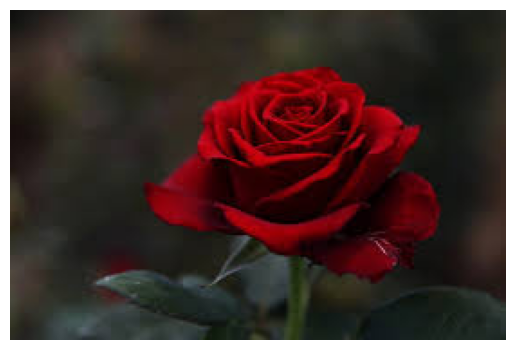

In [12]:
import cv2
import numpy as np
import os
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier as  rf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

dataset_path = r"C:\Users\student\Desktop\flowers"  
classes = os.listdir(dataset_path)


def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((128,))
    return np.mean(descriptors, axis=0) 

from skimage.feature import hog

def extract_hog_features(image):
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                      orientations=9, visualize=True)  # Removed multichannel=False
    return features

def extract_gloh_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((128,))
    return np.var(descriptors, axis=0)  
X, y = [], []

for label, flower in enumerate(classes):
    flower_path = os.path.join(dataset_path, flower)
    
    for img_name in os.listdir(flower_path):
        img_path = os.path.join(flower_path, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128, 128))  
        
     
        sift_feat = extract_sift_features(image)
        hog_feat = extract_hog_features(image)
        gloh_feat = extract_gloh_features(image)
        
       
        features = np.hstack((sift_feat, hog_feat, gloh_feat))
        X.append(features)
        y.append(label)


X = np.array(X)
y = np.array(y)


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



clf=rf(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f" Model Training Complete. Accuracy: {accuracy:.4f}")


def classify_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    sift_feat = extract_sift_features(image)
    hog_feat = extract_hog_features(image)
    gloh_feat = extract_gloh_features(image)
    features = np.hstack((sift_feat, hog_feat, gloh_feat)).reshape(1, -1)
    features = scaler.transform(features)
    pred_label = clf.predict(features)[0]
    predicted_class = classes[pred_label]

    print(f" Predicted Flower Class: {predicted_class}")

t = r"C:\Users\student\Desktop\test.jpg"


image = cv2.imread(t)  
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(image)
classify_image(t)


number of estimated clusters : 5


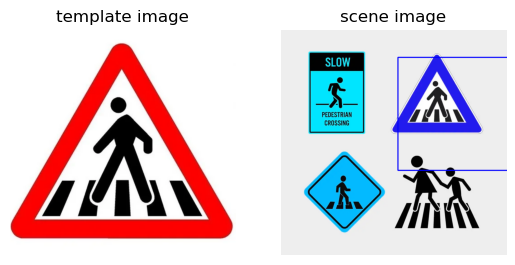

In [5]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth

img_rgb = cv2.imread(r"C:\Users\hanal\Desktop\w2.jpg") 
img2 = cv2.imread(r"C:\Users\hanal\Desktop\w2.jpg")
img1 = cv2.imread(r"C:\Users\hanal\Desktop\w1.jpg")
alg = cv2.xfeatures2d.SIFT_create()
kp1, des1 = alg.detectAndCompute(img1, None)
kp2, des2 = alg.detectAndCompute(img2, None)
x = np.array([kp2[0].pt])
for i in range(len(kp2)):
    x = np.append(x, [kp2[i].pt], axis=0)
x = x[1:len(x)]
bandwidth = estimate_bandwidth(x, quantile=0.1, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(x)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)
s = [None] * n_clusters_
for i in range(n_clusters_):
    l = ms.labels_
    d, = np.where(l == i)
    s[i] = list(kp2[xx] for xx in d)
des2_ = des2
for i in range(n_clusters_):
    kp2 = s[i]
    l = ms.labels_
    d, = np.where(l == i)
    des2 = des2_[d, ]

    if(len(kp2)<2 or len(kp1)<2):
        continue

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    des1 = np.float32(des1)
    des2 = np.float32(des2)

    matches = flann.knnMatch(des1, des2, 2)
    good = []
    for m,n in matches:
        if m.distance < 0.5*n.distance:
            good.append(m)
    if len(good)>3:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2)

        if M is None:
            print ("No Homography")
        else:
            h, w = img1.shape[:2]
        corners = np.float32([ [0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0] ]).reshape(-1, 1, 2)
        transformedCorners = cv2.perspectiveTransform(corners, M)
        
        x=int(transformedCorners[0][0][0])
        y=int(transformedCorners[0][0][1])
        cv2.rectangle(img_rgb, (x,y), (x+w,y+h), (0,0,255), 3)
        img2 = cv2.polylines(img2, [np.int32(transformedCorners)], True, (0, 0, 255), 2, cv2.LINE_AA)
        
    else:
        
        matchesMask = None
img=cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.title('template image')
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.title('scene image')
plt.axis('off')
plt.imshow(img_rgb)